In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import pandas as pd
from pandas import DataFrame as dframe
import cvxpy as cv

In [2]:
def Dic(feat_l_tr,feat_r_tr): #入力の配列は2次元配列である必要がある
    feat_tr = np.concatenate([feat_l_tr, feat_r_tr],0)
    return feat_tr

In [3]:
#各クラスの特徴ベクトルの配列の列数を格納した配列を引数にすればもう少し拡張性が上がる
def SGRM(feat_tr,feat_tr_dic_1,feat_tr_dic_2,feat_tr_dic_3,feat_tr_dic,feat_l_te,matrix_index):
    λ_1 = 0.04
    λ_2 = 0.05
    answer = np.zeros(feat_l_te.shape[1])
    SGRM_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    SGRM_l_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    SGRM_r_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    for i in range(feat_l_te.shape[1]):
        u = cv.Variable((feat_tr_dic.shape[1],1)) #目的関数の次元
        objective = cv.Minimize(0.5*(cv.norm(feat_tr_dic@u-feat_l_te[:,i,np.newaxis],2)**2)
                                +λ_1*cv.norm(u[:,0],1)
                                +λ_2*(cv.norm(u[0:feat_tr.shape[0],0],2)
                                      +cv.norm(u[feat_tr.shape[0]:feat_tr_dic_1.shape[0],0],2)
                                     +cv.norm(u[feat_tr_dic_1.shape[0]:feat_tr_dic_2.shape[0],0],2)
                                     +cv.norm(u[feat_tr_dic_2.shape[0]:feat_tr_dic_3.shape[0],0],2)
                                     +cv.norm(u[feat_tr_dic_3.shape[0]:feat_tr_dic.shape[0],0],2)))
                                     #+cv.norm(u[feat_tr_dic_4.shape[0]:feat_tr_dic_5.shape[0],0],2)
                                     #+cv.norm(u[feat_tr_dic_5.shape[0]:feat_tr_dic_6.shape[0],0],2)
                                     #+cv.norm(u[feat_tr_dic_6.shape[0]:feat_tr_dic.shape[0],0],2)))
        #constraints = [u == 0.5*(cv.norm(feat_tr_dic@u-feat_l_te[:,i,np.newaxis],2)**2)+λ_1*cv.norm(u[:,0],1)
                       #+λ_2*(cv.norm(u[0:feat_tr.shape[0],0],2)
                             #+cv.norm(u[feat_tr.shape[0]:feat_tr_dic_1.shape[0],0],2)
                             #+cv.norm(u[feat_tr_dic_1.shape[0]:feat_tr_dic_2.shape[0],0],2)
                             #+cv.norm(u[feat_tr_dic_2.shape[0]:feat_tr_dic_3.shape[0],0],2)
                             #+cv.norm(u[feat_tr_dic_3.shape[0]:feat_tr_dic.shape[0],0],2))] 
                    
        prob = cv.Problem(objective)
        result = prob.solve()
        #classVariableから値を取るためには.valueを付ける
        SGRM_Cla[:,i] = np.squeeze(u.value)
        #各クラスに関連する表現ベクトルの値を抜き出す
        #lは仕切りの値
        l = 0
        j = 0
        while j < matrix_index.shape[0]-1:
            SGRM_l_Cla[l:l+matrix_index[j],i] = SGRM_Cla[l:l+matrix_index[j],i]     
            l = l + matrix_index[j]
            j = j + 1
            SGRM_r_Cla[l:l+matrix_index[j],i] = SGRM_Cla[l:l+matrix_index[j],i]
            l = l + matrix_index[j]
            j = j + 1
    #パラメータを使って擬似的に各クラスのテスト信号の特徴ベクトルを作成
    dout_feat_l_te = np.zeros((feat_l_te.shape[0], feat_l_te.shape[1]))
    dout_feat_r_te = np.zeros((feat_l_te.shape[0], feat_l_te.shape[1])) 
    for i in range(feat_l_te.shape[1]):
        dout_feat_l_te[:,i] = feat_tr_dic@SGRM_l_Cla[:,i]
    for i in range(feat_l_te.shape[1]):
        dout_feat_r_te[:,i] = feat_tr_dic@SGRM_r_Cla[:,i]
    #作成した擬似特徴ベクトルとの残差を求める
    R_l =  np.zeros((feat_l_te.shape[0], feat_l_te.shape[1])) #残差を格納するための配列
    R_r =  np.zeros((feat_l_te.shape[0], feat_l_te.shape[1]))  
    for i in range(feat_l_te.shape[1]):
        R_l[:,i] = feat_l_te[:,i]-dout_feat_l_te[:,i]
        R_r[:,i] = feat_l_te[:,i]-dout_feat_r_te[:,i]
        if np.linalg.norm(R_l[:,i], ord=2) < np.linalg.norm(R_r[:,i], ord=2):
            answer[i] = 1
        elif np.linalg.norm(R_l[:,i], ord=2) > np.linalg.norm(R_r[:,i], ord=2):
            answer[i] = 2
    return answer

In [4]:
def SGRM_test(filename1,filename2,filename3,filename4,C1_K1,C2_K1,C1_K2,C2_K2,C1_K3,C2_K3,C1_K4,C2_K4):
    #対象被験者の特徴ベクトルをMATLABから入手
    feat_C1 = np.loadtxt(filename1,delimiter=",")
    feat_C2 = np.loadtxt(filename2,delimiter=",")
    feat_Test_C1 = np.loadtxt(filename3,delimiter=",")
    feat_Test_C2 = np.loadtxt(filename4,delimiter=",")
    #非対象被験者の特徴ベクトルをMATLABから入手
    feat_C1_K1 = np.loadtxt(C1_K1,delimiter=",")
    feat_C2_K1 = np.loadtxt(C2_K1,delimiter=",")
    feat_C1_K2 = np.loadtxt(C1_K2,delimiter=",")
    feat_C2_K2 = np.loadtxt(C1_K2,delimiter=",")
    feat_C1_K3 = np.loadtxt(C1_K3,delimiter=",")
    feat_C2_K3 = np.loadtxt(C1_K3,delimiter=",")
    feat_C1_K4 = np.loadtxt(C1_K4,delimiter=",")
    feat_C2_K4 = np.loadtxt(C1_K4,delimiter=",")
    #Tは被験者の試行回数である
    feat_tr = Dic(feat_C1,feat_C2)
    #非対象被験者の特徴ベクトルも同様の処理を行う
    feat_tr_K1 = Dic(feat_C1_K1,feat_C2_K1)
    feat_tr_K2 = Dic(feat_C1_K2,feat_C2_K2)
    feat_tr_K3 = Dic(feat_C1_K3,feat_C2_K3)
    feat_tr_K4 = Dic(feat_C1_K4,feat_C2_K4)

    #それぞれの特徴ベクトルをつなげる
    feat_tr_dic_1 = Dic(feat_tr,feat_tr_K1)
    feat_tr_dic_2 = Dic(feat_tr_dic_1,feat_tr_K2)
    feat_tr_dic_3 = Dic(feat_tr_dic_2,feat_tr_K3)
    feat_tr_dic = Dic(feat_tr_dic_3,feat_tr_K4).T
    #feat_tr_dicはすべての特徴ベクトルをつなげたもの
    #まず、分類に用いるテストデータの特徴ベクトルを2次元に変換
    feat_l_te = feat_Test_C1;
    feat_r_te = feat_Test_C2;
    feat_l_te = feat_l_te.T
    feat_r_te = feat_r_te.T

    matrix_index = np.array([feat_C1.shape[0],feat_C2.shape[0],feat_C1_K1.shape[0],feat_C2_K1.shape[0],feat_C1_K2.shape[0],feat_C2_K2.shape[0],
                        feat_C1_K3.shape[0],feat_C2_K3.shape[0],feat_C1_K4.shape[0],feat_C2_K4.shape[0]])
    answer1 = SGRM(feat_tr,feat_tr_dic_1,feat_tr_dic_2,feat_tr_dic_3,feat_tr_dic,feat_l_te,matrix_index)
    answer2 = SGRM(feat_tr,feat_tr_dic_1,feat_tr_dic_2,feat_tr_dic_3,feat_tr_dic,feat_r_te,matrix_index)
    x1 = 0
    x2 = 0
    for i in range(answer1.shape[0]):
        if answer1[i] == 1:
            x1 = x1 + 1
        if answer2[i] == 2:
            x2 = x2 + 1
        temp1 = ((x1)/(answer1.shape[0]))*100
        temp2 = ((x2)/(answer2.shape[0]))*100
        temp = ((x1+x2)/(answer1.shape[0]+answer2.shape[0]))*100
                    
    return temp,temp1,temp2

In [5]:
#train=20,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_25/feat_left_A01T_25_K0.txt","feat_2a_250Hz_25/feat_right_A01T_25_K0.txt","feat_2a_250Hz_25/feat_test_left_A01T_25.txt","feat_2a_250Hz_25/feat_test_right_A01T_25.txt"
                           ,"feat_2a_250Hz_30/feat_left_A02T_30.txt","feat_2a_250Hz_30/feat_right_A02T_30.txt","feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A06T_30.txt","feat_2a_250Hz_30/feat_right_A06T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_25/feat_left_A02T_25_K0.txt","feat_2a_250Hz_25/feat_right_A02T_25_K0.txt","feat_2a_250Hz_25/feat_test_left_A02T_25.txt","feat_2a_250Hz_25/feat_test_right_A02T_25.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A06T_30.txt","feat_2a_250Hz_30/feat_right_A06T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_25/feat_left_A03T_25_K0.txt","feat_2a_250Hz_25/feat_right_A03T_25_K0.txt","feat_2a_250Hz_25/feat_test_left_A03T_25.txt","feat_2a_250Hz_25/feat_test_right_A03T_25.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A02T_30.txt","feat_2a_250Hz_30/feat_right_A02T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A06T_30.txt","feat_2a_250Hz_30/feat_right_A06T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_25/feat_left_A07T_25_K0.txt","feat_2a_250Hz_25/feat_right_A07T_25_K0.txt","feat_2a_250Hz_25/feat_test_left_A07T_25.txt","feat_2a_250Hz_25/feat_test_right_A07T_25.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A02T_30.txt","feat_2a_250Hz_30/feat_right_A02T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_25/feat_left_A08T_25_K0.txt","feat_2a_250Hz_25/feat_right_A08T_25_K0.txt","feat_2a_250Hz_25/feat_test_left_A08T_25.txt","feat_2a_250Hz_25/feat_test_right_A08T_25.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A02T_30.txt","feat_2a_250Hz_30/feat_right_A02T_30.txt","feat_2a_250Hz_30/feat_left_A09T_30.txt","feat_2a_250Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_25/feat_left_A09T_25_K0.txt","feat_2a_250Hz_25/feat_right_A09T_25_K0.txt","feat_2a_250Hz_25/feat_test_left_A09T_25.txt","feat_2a_250Hz_25/feat_test_right_A09T_25.txt"
                           ,"feat_2a_250Hz_30/feat_left_A02T_30.txt","feat_2a_250Hz_30/feat_right_A02T_30.txt","feat_2a_250Hz_30/feat_left_A03T_30.txt","feat_2a_250Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30/feat_left_A01T_30.txt","feat_2a_250Hz_30/feat_right_A01T_30.txt","feat_2a_250Hz_30/feat_left_A06T_30.txt","feat_2a_250Hz_30/feat_right_A06T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([6, 3])
print(probability_1)

C:\Users\takehara kouta\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


[[ 48.75  97.5    0.  ]
 [ 51.25 100.     2.5 ]
 [ 50.     0.   100.  ]
 [ 53.75  67.5   40.  ]
 [ 52.5   22.5   82.5 ]
 [ 50.   100.     0.  ]]


In [6]:
#train=20,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_25/feat_left_A01T_25_K0.txt","feat_2a_250Hz_25/feat_right_A01T_25_K0.txt","feat_2a_250Hz_25/feat_test_left_A01T_25.txt","feat_2a_250Hz_25/feat_test_right_A01T_25.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A02T_30.txt","feat_2a_250Hz_30_2/feat_right_A02T_30.txt","feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A06T_30.txt","feat_2a_250Hz_30_2/feat_right_A06T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_25/feat_left_A02T_25_K0.txt","feat_2a_250Hz_25/feat_right_A02T_25_K0.txt","feat_2a_250Hz_25/feat_test_left_A02T_25.txt","feat_2a_250Hz_25/feat_test_right_A02T_25.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A06T_30.txt","feat_2a_250Hz_30_2/feat_right_A06T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_25/feat_left_A03T_25_K0.txt","feat_2a_250Hz_25/feat_right_A03T_25_K0.txt","feat_2a_250Hz_25/feat_test_left_A03T_25.txt","feat_2a_250Hz_25/feat_test_right_A03T_25.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A02T_30.txt","feat_2a_250Hz_30_2/feat_right_A02T_30.txt","feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A06T_30.txt","feat_2a_250Hz_30_2/feat_right_A06T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_25/feat_left_A07T_25_K0.txt","feat_2a_250Hz_25/feat_right_A07T_25_K0.txt","feat_2a_250Hz_25/feat_test_left_A07T_25.txt","feat_2a_250Hz_25/feat_test_right_A07T_25.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A02T_30.txt","feat_2a_250Hz_30_2/feat_right_A02T_30.txt","feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_25/feat_left_A08T_25_K0.txt","feat_2a_250Hz_25/feat_right_A08T_25_K0.txt","feat_2a_250Hz_25/feat_test_left_A08T_25.txt","feat_2a_250Hz_25/feat_test_right_A08T_25.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A02T_30.txt","feat_2a_250Hz_30_2/feat_right_A02T_30.txt","feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A09T_30.txt","feat_2a_250Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_25/feat_left_A09T_25_K0.txt","feat_2a_250Hz_25/feat_right_A09T_25_K0.txt","feat_2a_250Hz_25/feat_test_left_A09T_25.txt","feat_2a_250Hz_25/feat_test_right_A09T_25.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A02T_30.txt","feat_2a_250Hz_30_2/feat_right_A02T_30.txt","feat_2a_250Hz_30_2/feat_left_A03T_30.txt","feat_2a_250Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_2/feat_left_A01T_30.txt","feat_2a_250Hz_30_2/feat_right_A01T_30.txt","feat_2a_250Hz_30_2/feat_left_A06T_30.txt","feat_2a_250Hz_30_2/feat_right_A06T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([6, 3])
print(probability_2)

[[ 48.75  90.     7.5 ]
 [ 56.25  97.5   15.  ]
 [ 50.     0.   100.  ]
 [ 50.    27.5   72.5 ]
 [ 51.25  52.5   50.  ]
 [ 58.    72.    44.  ]]


In [7]:
#train=20,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_25/feat_left_A01T_25_K0.txt","feat_2a_250Hz_25/feat_right_A01T_25_K0.txt","feat_2a_250Hz_25/feat_test_left_A01T_25.txt","feat_2a_250Hz_25/feat_test_right_A01T_25.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A02T_30.txt","feat_2a_250Hz_30_3/feat_right_A02T_30.txt","feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A06T_30.txt","feat_2a_250Hz_30_3/feat_right_A06T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_25/feat_left_A02T_25_K0.txt","feat_2a_250Hz_25/feat_right_A02T_25_K0.txt","feat_2a_250Hz_25/feat_test_left_A02T_25.txt","feat_2a_250Hz_25/feat_test_right_A02T_25.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A06T_30.txt","feat_2a_250Hz_30_3/feat_right_A06T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_25/feat_left_A03T_25_K0.txt","feat_2a_250Hz_25/feat_right_A03T_25_K0.txt","feat_2a_250Hz_25/feat_test_left_A03T_25.txt","feat_2a_250Hz_25/feat_test_right_A03T_25.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A02T_30.txt","feat_2a_250Hz_30_3/feat_right_A02T_30.txt","feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A06T_30.txt","feat_2a_250Hz_30_3/feat_right_A06T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_25/feat_left_A07T_25_K0.txt","feat_2a_250Hz_25/feat_right_A07T_25_K0.txt","feat_2a_250Hz_25/feat_test_left_A07T_25.txt","feat_2a_250Hz_25/feat_test_right_A07T_25.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A02T_30.txt","feat_2a_250Hz_30_3/feat_right_A02T_30.txt","feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_25/feat_left_A08T_25_K0.txt","feat_2a_250Hz_25/feat_right_A08T_25_K0.txt","feat_2a_250Hz_25/feat_test_left_A08T_25.txt","feat_2a_250Hz_25/feat_test_right_A08T_25.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A02T_30.txt","feat_2a_250Hz_30_3/feat_right_A02T_30.txt","feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A09T_30.txt","feat_2a_250Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_250Hz_25/feat_left_A09T_25_K0.txt","feat_2a_250Hz_25/feat_right_A09T_25_K0.txt","feat_2a_250Hz_25/feat_test_left_A09T_25.txt","feat_2a_250Hz_25/feat_test_right_A09T_25.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A02T_30.txt","feat_2a_250Hz_30_3/feat_right_A02T_30.txt","feat_2a_250Hz_30_3/feat_left_A03T_30.txt","feat_2a_250Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_250Hz_30_3/feat_left_A01T_30.txt","feat_2a_250Hz_30_3/feat_right_A01T_30.txt","feat_2a_250Hz_30_3/feat_left_A06T_30.txt","feat_2a_250Hz_30_3/feat_right_A06T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([6, 3])
print(probability_3)

[[ 45.    80.    10.  ]
 [ 50.   100.     0.  ]
 [ 52.5    5.   100.  ]
 [ 51.25  67.5   35.  ]
 [ 55.    75.    35.  ]
 [ 54.    60.    48.  ]]


In [8]:
p_average_250Hz = (probability_1+probability_2+probability_3)/3
print(p_average_250Hz)

[[ 47.5         89.16666667   5.83333333]
 [ 52.5         99.16666667   5.83333333]
 [ 50.83333333   1.66666667 100.        ]
 [ 51.66666667  54.16666667  49.16666667]
 [ 52.91666667  50.          55.83333333]
 [ 54.          77.33333333  30.66666667]]


In [9]:
#train=20,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_25/feat_left_A01T_25_K0.txt","feat_2a_125Hz_25/feat_right_A01T_25_K0.txt","feat_2a_125Hz_25/feat_test_left_A01T_25.txt","feat_2a_125Hz_25/feat_test_right_A01T_25.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A06T_30.txt","feat_2a_125Hz_30/feat_right_A06T_30.txt","feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_25/feat_left_A02T_25_K0.txt","feat_2a_125Hz_25/feat_right_A02T_25_K0.txt","feat_2a_125Hz_25/feat_test_left_A02T_25.txt","feat_2a_125Hz_25/feat_test_right_A02T_25.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A06T_30.txt","feat_2a_125Hz_30/feat_right_A06T_30.txt","feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_25/feat_left_A03T_25_K0.txt","feat_2a_125Hz_25/feat_right_A03T_25_K0.txt","feat_2a_125Hz_25/feat_test_left_A03T_25.txt","feat_2a_125Hz_25/feat_test_right_A03T_25.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A06T_30.txt","feat_2a_125Hz_30/feat_right_A06T_30.txt","feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_25/feat_left_A07T_25_K0.txt","feat_2a_125Hz_25/feat_right_A07T_25_K0.txt","feat_2a_125Hz_25/feat_test_left_A07T_25.txt","feat_2a_125Hz_25/feat_test_right_A07T_25.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_25/feat_left_A08T_25_K0.txt","feat_2a_125Hz_25/feat_right_A08T_25_K0.txt","feat_2a_125Hz_25/feat_test_left_A08T_25.txt","feat_2a_125Hz_25/feat_test_right_A08T_25.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A09T_30.txt","feat_2a_125Hz_30/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_25/feat_left_A09T_25_K0.txt","feat_2a_125Hz_25/feat_right_A09T_25_K0.txt","feat_2a_125Hz_25/feat_test_left_A09T_25.txt","feat_2a_125Hz_25/feat_test_right_A09T_25.txt"
                           ,"feat_2a_125Hz_30/feat_left_A01T_30.txt","feat_2a_125Hz_30/feat_right_A01T_30.txt","feat_2a_125Hz_30/feat_left_A03T_30.txt","feat_2a_125Hz_30/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30/feat_left_A02T_30.txt","feat_2a_125Hz_30/feat_right_A02T_30.txt","feat_2a_125Hz_30/feat_left_A06T_30.txt","feat_2a_125Hz_30/feat_right_A06T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_1 = probability.reshape([6, 3])
print(probability_1)

[[ 51.25  12.5   90.  ]
 [ 43.75  55.    32.5 ]
 [ 50.     0.   100.  ]
 [ 50.     0.   100.  ]
 [ 50.   100.     0.  ]
 [ 52.    36.    68.  ]]


In [10]:
#train=20,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_25/feat_left_A01T_25_K0.txt","feat_2a_125Hz_25/feat_right_A01T_25_K0.txt","feat_2a_125Hz_25/feat_test_left_A01T_25.txt","feat_2a_125Hz_25/feat_test_right_A01T_25.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A02T_30.txt","feat_2a_125Hz_30_2/feat_right_A02T_30.txt","feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A06T_30.txt","feat_2a_125Hz_30_2/feat_right_A06T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_25/feat_left_A02T_25_K0.txt","feat_2a_125Hz_25/feat_right_A02T_25_K0.txt","feat_2a_125Hz_25/feat_test_left_A02T_25.txt","feat_2a_125Hz_25/feat_test_right_A02T_25.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A06T_30.txt","feat_2a_125Hz_30_2/feat_right_A06T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_25/feat_left_A03T_25_K0.txt","feat_2a_125Hz_25/feat_right_A03T_25_K0.txt","feat_2a_125Hz_25/feat_test_left_A03T_25.txt","feat_2a_125Hz_25/feat_test_right_A03T_25.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A02T_30.txt","feat_2a_125Hz_30_2/feat_right_A02T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A06T_30.txt","feat_2a_125Hz_30_2/feat_right_A06T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_25/feat_left_A07T_25_K0.txt","feat_2a_125Hz_25/feat_right_A07T_25_K0.txt","feat_2a_125Hz_25/feat_test_left_A07T_25.txt","feat_2a_125Hz_25/feat_test_right_A07T_25.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A02T_30.txt","feat_2a_125Hz_30_2/feat_right_A02T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_25/feat_left_A08T_25_K0.txt","feat_2a_125Hz_25/feat_right_A08T_25_K0.txt","feat_2a_125Hz_25/feat_test_left_A08T_25.txt","feat_2a_125Hz_25/feat_test_right_A08T_25.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A02T_30.txt","feat_2a_125Hz_30_2/feat_right_A02T_30.txt","feat_2a_125Hz_30_2/feat_left_A09T_30.txt","feat_2a_125Hz_30_2/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_25/feat_left_A09T_25_K0.txt","feat_2a_125Hz_25/feat_right_A09T_25_K0.txt","feat_2a_125Hz_25/feat_test_left_A09T_25.txt","feat_2a_125Hz_25/feat_test_right_A09T_25.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A01T_30.txt","feat_2a_125Hz_30_2/feat_right_A01T_30.txt","feat_2a_125Hz_30_2/feat_left_A03T_30.txt","feat_2a_125Hz_30_2/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_2/feat_left_A02T_30.txt","feat_2a_125Hz_30_2/feat_right_A02T_30.txt","feat_2a_125Hz_30_2/feat_left_A06T_30.txt","feat_2a_125Hz_30_2/feat_right_A06T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_2 = probability.reshape([6, 3])
print(probability_2)

[[ 40.   15.   65. ]
 [ 45.   42.5  47.5]
 [ 55.   15.   95. ]
 [ 50.    0.  100. ]
 [ 55.   95.   15. ]
 [ 52.   28.   76. ]]


In [11]:
#train=20,test=40で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_25/feat_left_A01T_25_K0.txt","feat_2a_125Hz_25/feat_right_A01T_25_K0.txt","feat_2a_125Hz_25/feat_test_left_A01T_25.txt","feat_2a_125Hz_25/feat_test_right_A01T_25.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A02T_30.txt","feat_2a_125Hz_30_3/feat_right_A02T_30.txt","feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A06T_30.txt","feat_2a_125Hz_30_3/feat_right_A06T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_25/feat_left_A02T_25_K0.txt","feat_2a_125Hz_25/feat_right_A02T_25_K0.txt","feat_2a_125Hz_25/feat_test_left_A02T_25.txt","feat_2a_125Hz_25/feat_test_right_A02T_25.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A06T_30.txt","feat_2a_125Hz_30_3/feat_right_A06T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_25/feat_left_A03T_25_K0.txt","feat_2a_125Hz_25/feat_right_A03T_25_K0.txt","feat_2a_125Hz_25/feat_test_left_A03T_25.txt","feat_2a_125Hz_25/feat_test_right_A03T_25.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A02T_30.txt","feat_2a_125Hz_30_3/feat_right_A02T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A06T_30.txt","feat_2a_125Hz_30_3/feat_right_A06T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_25/feat_left_A07T_25_K0.txt","feat_2a_125Hz_25/feat_right_A07T_25_K0.txt","feat_2a_125Hz_25/feat_test_left_A07T_25.txt","feat_2a_125Hz_25/feat_test_right_A07T_25.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A02T_30.txt","feat_2a_125Hz_30_3/feat_right_A02T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_25/feat_left_A08T_25_K0.txt","feat_2a_125Hz_25/feat_right_A08T_25_K0.txt","feat_2a_125Hz_25/feat_test_left_A08T_25.txt","feat_2a_125Hz_25/feat_test_right_A08T_25.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A02T_30.txt","feat_2a_125Hz_30_3/feat_right_A02T_30.txt","feat_2a_125Hz_30_3/feat_left_A09T_30.txt","feat_2a_125Hz_30_3/feat_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SGRM_test("feat_2a_125Hz_25/feat_left_A09T_25_K0.txt","feat_2a_125Hz_25/feat_right_A09T_25_K0.txt","feat_2a_125Hz_25/feat_test_left_A09T_25.txt","feat_2a_125Hz_25/feat_test_right_A09T_25.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A01T_30.txt","feat_2a_125Hz_30_3/feat_right_A01T_30.txt","feat_2a_125Hz_30_3/feat_left_A03T_30.txt","feat_2a_125Hz_30_3/feat_right_A03T_30.txt"
                           ,"feat_2a_125Hz_30_3/feat_left_A02T_30.txt","feat_2a_125Hz_30_3/feat_right_A02T_30.txt","feat_2a_125Hz_30_3/feat_left_A06T_30.txt","feat_2a_125Hz_30_3/feat_right_A06T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)

probability_3 = probability.reshape([6, 3])
print(probability_3)

[[ 46.25   7.5   85.  ]
 [ 51.25  42.5   60.  ]
 [ 52.5    7.5   97.5 ]
 [ 50.     0.   100.  ]
 [ 50.    97.5    2.5 ]
 [ 48.     4.    92.  ]]


In [12]:
p_average_125Hz = (probability_1+probability_2+probability_3)/3
print(p_average_125Hz)

[[ 45.83333333  11.66666667  80.        ]
 [ 46.66666667  46.66666667  46.66666667]
 [ 52.5          7.5         97.5       ]
 [ 50.           0.         100.        ]
 [ 51.66666667  97.5          5.83333333]
 [ 50.66666667  22.66666667  78.66666667]]


In [13]:
a_20 = 0; a_30 = 0;
for i in range(6):
    a_20 = a_20 + p_average_250Hz[i,0] 
    a_30 = a_30 + p_average_125Hz[i,0] 
    
a_20 = a_20/6
a_30 = a_30/6
print(a_20,a_30)

51.569444444444436 49.55555555555555


[[45.83333333 46.66666667 52.5        50.         51.66666667 50.66666667]
 [47.5        52.5        50.83333333 51.66666667 52.91666667 54.        ]]


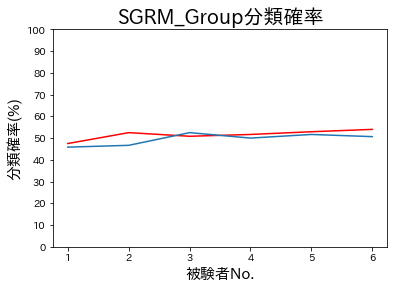

In [14]:
import matplotlib.pyplot as plt
import japanize_matplotlib
y = np.array([])
x = np.arange(1, 7, step=1)
y = np.append(p_average_250Hz[:,0],y)
y = np.append(p_average_125Hz[:,0],y)
y = y.reshape([2,6])
print(y)
plt.plot(x,y[1],"red")
plt.plot(x,y[0])
plt.title("SGRM_Group分類確率", {"fontsize":20})
plt.xlabel("被験者No.", {"fontsize":15})
plt.ylabel("分類確率(%)", {"fontsize":15})
plt.xticks(np.arange(1, 7, step=1))
plt.yticks(np.arange(0, 110, step=10))
plt.savefig("2a_SGRM_group_probability.pdf")
plt.show()